# Project - Fifth Requierement

### Import libraries and packages

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import norm
from copy import deepcopy
from tqdm import tqdm
from itertools import product
from collections import deque
from scipy.optimize import linprog

## Environment

In [2]:
class Environment:
    def __init__(self):
        pass
    def round(self, a_t):
        pass

In [3]:
class PricingEnvironmentMultiProductPiecewiseMean:
    def __init__(self, cost_vector, mean_valuation_schedule, std_valuations, buyers_per_round, total_rounds):
        """
        mean_valuations_list: list of 3 arrays, one for each interval (e.g. [mean_1, mean_2, mean_3])
        """
        self.cost_vector = np.array(cost_vector)
        self.mean_valuations_list = [np.array(m) for m in mean_valuation_schedule]
        self.std_valuations = np.array(std_valuations)
        self.buyers_per_round = buyers_per_round
        self.total_rounds = total_rounds
        self.current_round = 0

        # Compute the round thresholds
        self.interval_size = total_rounds // 3

    def round(self, p_t_vector):
        # Determine the current interval
        if self.current_round < self.interval_size:
            mean_valuations = self.mean_valuations_list[0]

        elif self.current_round < 2 * self.interval_size:
            mean_valuations = self.mean_valuations_list[1]

        else:
            mean_valuations = self.mean_valuations_list[2]


        # Compute the probability of buying and sample sales
        prob_buy = 1 - norm.cdf(np.array(p_t_vector), loc=mean_valuations, scale=self.std_valuations)
        num_sales = np.random.binomial(n=self.buyers_per_round, p=prob_buy)

        # Compute reward
        reward = (np.array(p_t_vector) - self.cost_vector) * num_sales
        self.current_round += 1
        return num_sales, reward


### Global settings

In [4]:
# --- Global Settings ---

N = 3                       # Number of products
T = 20000                   # Time horizon
n_trials = 1               # Independent trials

# --- Pricing Grid and Product Info ---

cost_vector = np.array([2.0, 2.5, 3.0])             # Costs per product
initial_values = np.array([5.0, 6.0, 5.5])          # Initial mean valuations
std_valuations = np.array([1.0, 1.2, 0.8])          # Std for each product

min_p = 0.0
max_p = int(np.max(initial_values) * 2)

K = 10
P = np.linspace(min_p, max_p, K)                    # Shared price grid for all products

assert np.all(cost_vector < initial_values), "Each cost must be less than its initial valuation"

# --- Market and Inventory Parameters ---

B = 120000 * N                                      # Total shared inventory

amplitudes = np.array([2.0, 1.5, 1.0])
periods = np.array([1000, 1500, 800])

buyers_per_round = 50                               # Number of buyers per round

# --- Other Parameters ---

zoom_end = 2 * max(periods)     # Show only up to 2x the max period in main plots
zoom_end_mini = 200             # Show only up to 200 rounds in mini plots
zoom_end_5 = 5000               # Start zooming 5k rounds
s = 30                          # random seed

# --- Formatter for Millions in the plots---
def millions_formatter(x, pos):
    return f'{x / 1e6:.1f}M'


mean_valuation_schedule = [
    [5.0, 8.0, 2.0],  # T1
    [9.0, 5.0, 1.5],  # T2
    [1.5, 6.5, 12.0],  # T3
]

env = PricingEnvironmentMultiProductPiecewiseMean(
    cost_vector=cost_vector,
    mean_valuation_schedule=mean_valuation_schedule,
    std_valuations=std_valuations,
    buyers_per_round=buyers_per_round,
    total_rounds=T
)


### Agent definition

In [5]:
class GlobalLinearProgramUCB_SW:
    def __init__(self, N, K, B, T, price_grids, scale=1.0):
        self.N = N
        self.K = K
        self.B = B
        self.T = T
        self.scale = scale
        self.price_grids = price_grids
        self.rho = B / T
        print(f"Using static rho = {self.rho}")
        self.t = 0
        self.inventory = B

        # All possible actions = super-arms
        self.actions = list(product(range(K), repeat=N))
        self.A = len(self.actions)

        # Sliding window size
        self.window_size = int(np.round(np.sqrt(T)))

        # Sliding-window buffers
        self.reward_window = [deque(maxlen=self.window_size) for _ in range(self.A)]
        self.sales_window = [deque(maxlen=self.window_size) for _ in range(self.A)]

        self.last_action_idx = None

    def pull_arm(self):
        if self.inventory < 1:
            self.last_action_idx = None
            return None

        if self.t < self.A:
            action_idx = self.t
        else:
            # Use windowed counts and means
            n_pulls = np.array([len(w) for w in self.reward_window])
            avg_rewards = np.array([np.mean(w) if len(w)>0 else 0 for w in self.reward_window])
            avg_sales   = np.array([np.mean(w) if len(w)>0 else 0 for w in self.sales_window])

            ucb = avg_rewards + self.scale * np.sqrt(2 * np.log(self.T) / np.maximum(1, n_pulls))
            lcb = avg_sales   - self.scale * np.sqrt(2 * np.log(self.T) / np.maximum(1, n_pulls))

            action_idx = self.solve_lp(ucb, lcb)

        self.last_action_idx = action_idx
        return self.actions[action_idx]

    def solve_lp(self, ucb_rewards, lcb_sales):
        c = -ucb_rewards
        A_ub = [lcb_sales]
        b_ub = [self.rho]
        A_eq = [np.ones(self.A)]
        b_eq = [1]
        bounds = [(0, 1)] * self.A

        res = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')
        if res.success:
            return np.random.choice(self.A, p=res.x)
        else:
            return np.argmax(ucb_rewards)

    def update(self, sales, total_reward):
        if self.last_action_idx is None:
            return

        idx = self.last_action_idx
       
        self.reward_window[idx].append(total_reward)
        self.sales_window[idx].append(np.sum(sales))

        
        self.inventory -= np.sum(sales)
        self.t += 1


In [6]:
np.random.seed(s)

rewards_trials = []

for trial in range(n_trials):
    
    env = PricingEnvironmentMultiProductPiecewiseMean(
        cost_vector=cost_vector,
        mean_valuation_schedule=mean_valuation_schedule,
        std_valuations=std_valuations,
        buyers_per_round=buyers_per_round,
        total_rounds=T
    )

    
    learner = GlobalLinearProgramUCB_SW(
        N=N,
        K=K,
        B=B,
        T=T,
        price_grids=P,
        scale=1.0  
    )

    total_reward = np.zeros(T)

    for t in tqdm(range(T)):
        action = learner.pull_arm()
        if action is None:
            break  

        
        prices = [P[i] for i in action]

        sales, reward = env.round(prices)
        learner.update(sales, reward)

        total_reward[t] = np.sum(reward)

    rewards_trials.append(total_reward)


avg_reward = np.mean(rewards_trials, axis=0)


Using static rho = 18.0


 78%|███████▊  | 15612/20000 [05:42<01:36, 45.60it/s] 


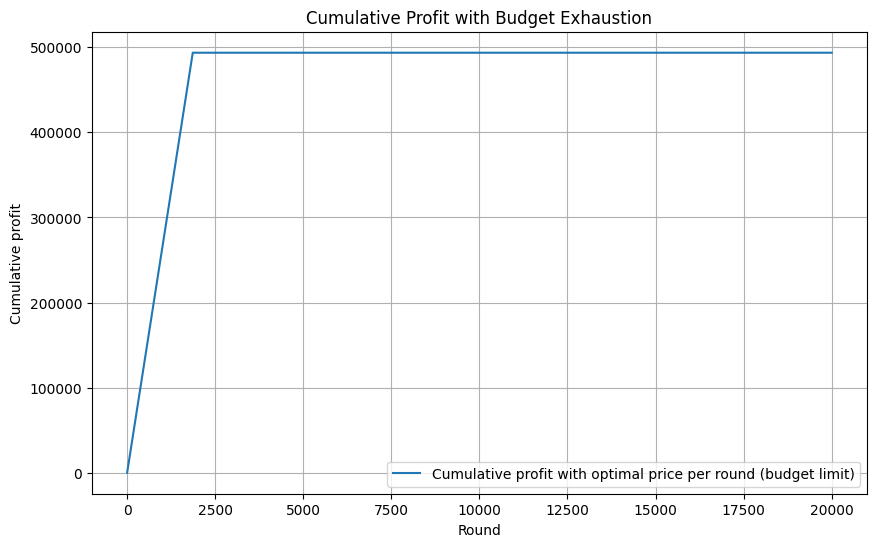

In [7]:
num_turns = len(mean_valuation_schedule)
rounds_per_turn = T // num_turns

profit_per_round = np.zeros(T)
cumulative_cost = 0

for turn_idx, mean_vals in enumerate(mean_valuation_schedule):
    start_round = turn_idx * rounds_per_turn
    end_round = (turn_idx + 1) * rounds_per_turn if turn_idx < num_turns - 1 else T

    for t in range(start_round, end_round):
        if cumulative_cost >= B:
           
            profit_per_round[t] = 0
            continue

        total_profit = 0
        total_cost = 0

        for i in range(N):
            mean_val = mean_vals[i]
            cost = cost_vector[i]
            std_val = std_valuations[i]

            
            expected_profits = []
            expected_demands = []
            for p in P:
                demand = buyers_per_round * (1 - norm.cdf(p, loc=mean_val, scale=std_val))
                profit = (p - cost) * demand
                expected_profits.append(profit)
                expected_demands.append(demand)
            expected_profits = np.array(expected_profits)
            expected_demands = np.array(expected_demands)

            idx_best = np.argmax(expected_profits)
            best_p = P[idx_best]
            best_demand = expected_demands[idx_best]
            best_profit = expected_profits[idx_best]

            cost_this_product = best_demand * cost

            
            budget_left = B - cumulative_cost
            if cost_this_product > budget_left:
                fraction = budget_left / cost_this_product
                best_demand *= fraction
                cost_this_product = budget_left
                best_profit = (best_p - cost) * best_demand

            total_profit += best_profit
            total_cost += cost_this_product

        profit_per_round[t] = total_profit
        cumulative_cost += total_cost

cum_profit = np.cumsum(profit_per_round)

plt.figure(figsize=(10, 6))
plt.plot(cum_profit, label='Cumulative profit with optimal price per round (budget limit)')
plt.xlabel("Round")
plt.ylabel("Cumulative profit")
plt.title("Cumulative Profit with Budget Exhaustion")
plt.legend()
plt.grid(True)
plt.show()



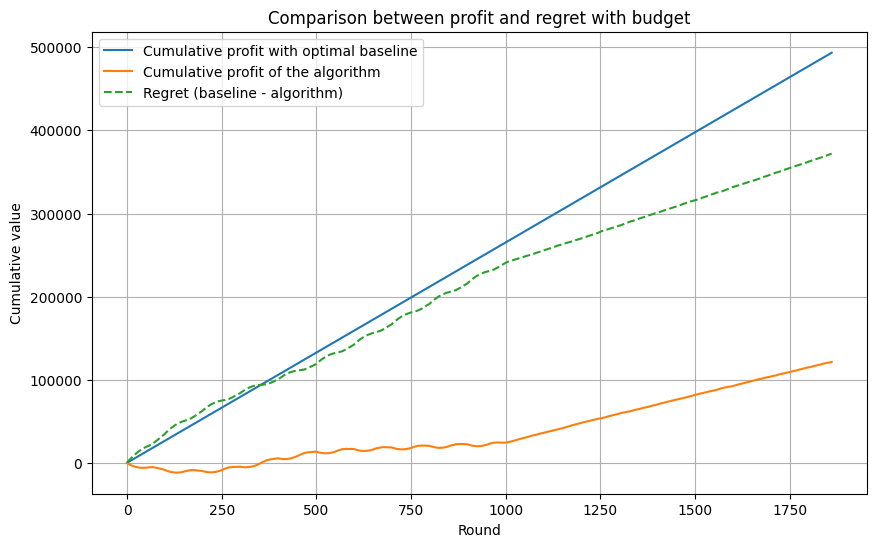

In [8]:
rewards_trials = np.array(rewards_trials)  

mean_rewards = np.mean(rewards_trials, axis=0) if rewards_trials.ndim == 2 else rewards_trials
cum_rewards = np.cumsum(mean_rewards)

budget_exhausted_round = np.argmax(profit_per_round == 0)  
if budget_exhausted_round == 0 and profit_per_round[0] != 0:
    
    budget_exhausted_round = T

cum_profit_trim = cum_profit[:budget_exhausted_round]
cum_rewards_trim = cum_rewards[:budget_exhausted_round]

regret = cum_profit_trim - cum_rewards_trim

plt.figure(figsize=(10, 6))
plt.plot(cum_profit_trim, label='Cumulative profit with optimal baseline')
plt.plot(cum_rewards_trim, label='Cumulative profit of the algorithm')
plt.plot(regret, label='Regret (baseline - algorithm)', linestyle='--')
plt.xlabel("Round")
plt.ylabel("Cumulative value")
plt.title("Comparison between profit and regret with budget")
plt.legend()
plt.grid(True)
plt.show()


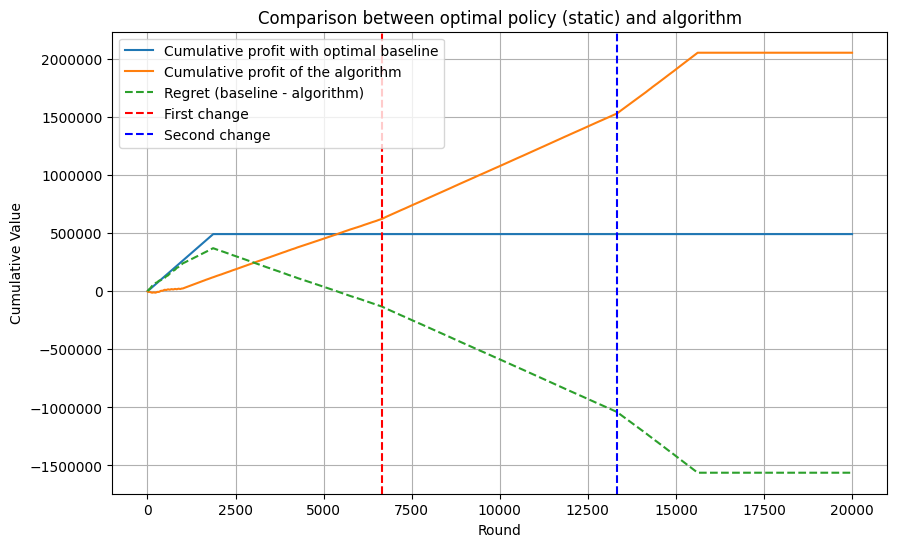

In [9]:
mean_rewards = np.mean(rewards_trials, axis=0) if rewards_trials.ndim == 2 else rewards_trials
cum_rewards = np.cumsum(mean_rewards)

budget_exhausted_round = np.argmax(profit_per_round == 0)  
if budget_exhausted_round == 0 and profit_per_round[0] != 0:
    budget_exhausted_round = T


cum_profit_trim = cum_profit[:budget_exhausted_round]

if budget_exhausted_round < T:
    plateau_value = cum_profit_trim[-1]
    cum_profit_trim = np.concatenate([cum_profit_trim, np.full(T - budget_exhausted_round, plateau_value)])


cum_rewards_trim = cum_rewards
if len(cum_rewards) < T:
    last_val = cum_rewards[-1]
    cum_rewards_trim = np.concatenate([cum_rewards, np.full(T - len(cum_rewards), last_val)])


regret = cum_profit_trim - cum_rewards_trim

x_axis = np.arange(1, T + 1)  

plt.figure(figsize=(10, 6))
plt.plot(x_axis, cum_profit_trim, label='Cumulative profit with optimal baseline')
plt.plot(x_axis, cum_rewards_trim, label='Cumulative profit of the algorithm')
plt.plot(x_axis, regret, label='Regret (baseline - algorithm)', linestyle='--')

plt.axvline(x=20000/3, color='red', linestyle='--', label='First change')
plt.axvline(x=20000/3*2, color='blue', linestyle='--', label='Second change')
plt.xlabel("Round")
plt.ylabel("Cumulative Value")
plt.title("Comparison between optimal policy (static) and algorithm")
plt.legend()
plt.grid(True)

plt.ticklabel_format(style='plain', axis='y')  

plt.show()

### Comparison with primal-dual method

#### Define the primal-dual agent

In [15]:
class EXP3P:
    def __init__(self, num_actions, gamma, eta, max_reward_scale):
        self.num_actions = num_actions
        self.gamma = gamma
        self.eta = eta
        self.weights = np.ones(num_actions)
        self.probabilities = np.zeros(num_actions)
        # Safe upper bound on absolute reward
        self.max_reward_scale = max_reward_scale

    def choose_action(self):
        sum_weights = np.sum(self.weights)
        self.probabilities = (1 - self.gamma) * (self.weights / sum_weights) + (self.gamma / self.num_actions)
        self.probabilities /= np.sum(self.probabilities)  # Just in case
        return np.random.choice(self.num_actions, p=self.probabilities)

    def update(self, chosen_action_idx, observed_reward):
        # Normalize reward and compute loss
        normalized_reward = observed_reward / self.max_reward_scale
        loss_t = (1 - normalized_reward) / 2
        estimated_loss = loss_t / self.probabilities[chosen_action_idx]
        self.weights[chosen_action_idx] *= np.exp(-self.eta * estimated_loss)

        # Normalize weights if needed
        w_sum = np.sum(self.weights)
        if w_sum < 1e-100 or w_sum > 1e100:
            self.weights /= np.max(self.weights)

class PrimalDualMultiProductPricingAgent:
    def __init__(self, prices, B, T, cost_vector, buyers_per_round, initial_lambda=0, learning_rate_lambda=0.01, exp3p_gamma=0.1, exp3p_eta=None):
        self.prices = prices
        self.K = len(prices) # Number of price options
        self.N = len(cost_vector) # Number of products

        self.B = B # Total budget
        self.T = T # Total time horizon
        self.cost_vector = np.array(cost_vector)
        self.buyers_per_round = buyers_per_round
        self.rho = B / T if T > 0 else 1e-8 # Initial target average sales per round
        self.lambda_t = initial_lambda
        self.eta_lambda = learning_rate_lambda
        self.current_round = 0
        self.remaining_budget = B

        # Determine a safe upper bound for reward scaling for EXP3P
        max_possible_sales_per_product = buyers_per_round
        max_possible_profit_per_product_per_round = (np.max(prices) - np.min(cost_vector)) * max_possible_sales_per_product
        self.max_reward_scale = max_possible_profit_per_product_per_round + (np.max(self.prices) * 2) * self.buyers_per_round
        if self.max_reward_scale == 0:
            self.max_reward_scale = 1.0

        # Init leargning rate in case not provided
        if exp3p_eta is None:
            exp3p_eta = np.sqrt(2 * np.log(self.K) / (self.K * self.T))
        # Initialize the products' regret minimizers
        self.product_regret_minimizers = [ EXP3P(num_actions=self.K, gamma=exp3p_gamma, eta=exp3p_eta, max_reward_scale=self.max_reward_scale) for _ in range(self.N) ]

        self.history_chosen_price_indices = []
        self.history_lambda = [self.lambda_t]
        self.history_total_sales = []
        self.history_total_rewards = []
        self.history_rho_target = []

    def choose_prices(self):
        chosen_prices = []
        chosen_indices = []
        for i in range(self.N):
            idx = self.product_regret_minimizers[i].choose_action()
            chosen_prices.append(self.prices[idx])
            chosen_indices.append(idx)

        self.history_chosen_price_indices.append(chosen_indices)
        return np.array(chosen_prices), chosen_indices

    def update(self, chosen_indices, sales_vector, rewards_vector):
        total_sales = np.sum(sales_vector)
        self.history_total_sales.append(total_sales)
        self.history_total_rewards.append(np.sum(rewards_vector))
        self.history_rho_target.append(self.rho) # Store current rho for plotting

        # Update the regret minimizers for each product
        for i in range(self.N):
            price = self.prices[chosen_indices[i]]
            cost = self.cost_vector[i]
            num_sales = sales_vector[i]

            rho_per_product = self.rho / self.N
            effective_reward = (price - cost) * num_sales - self.lambda_t * (num_sales - rho_per_product)
            self.product_regret_minimizers[i].update(chosen_indices[i], effective_reward)

        # Update budget
        self.remaining_budget -= total_sales
        self.current_round += 1
        rounds_left = self.T - self.current_round
        self.rho = self.remaining_budget / rounds_left if rounds_left > 0 else 0

        # Lambda update
        diff = total_sales - self.rho
        lambda_update = self.eta_lambda * diff
        self.lambda_t += lambda_update
        self.lambda_t = np.clip(self.lambda_t, 0, np.max(self.prices) * 2)
        self.history_lambda.append(self.lambda_t)

        if self.remaining_budget < 0:
            print(f"Budget exhausted at round {self.current_round}. Total sales: {np.sum(self.history_total_sales)}")
            return False
        return True

#### Run the experiment

In [16]:
# --- Global Settings ---

N = 3                       # Number of products
T = 20000                   # Time horizon
n_trials = 1               # Independent trials

# --- Pricing Grid and Product Info ---

cost_vector = np.array([2.0, 2.5, 3.0])             # Costs per product
initial_values = np.array([5.0, 6.0, 5.5])          # Initial mean valuations
std_valuations = np.array([1.0, 1.2, 0.8])          # Std for each product

min_p = 0.0
max_p = int(np.max(initial_values) * 2)

K = 10
P = np.linspace(min_p, max_p, K)                    # Shared price grid for all products

assert np.all(cost_vector < initial_values), "Each cost must be less than its initial valuation"

# --- Market and Inventory Parameters ---

B = 120000 * N                                      # Total shared inventory

amplitudes = np.array([2.0, 1.5, 1.0])
periods = np.array([1000, 1500, 800])

buyers_per_round = 50                               # Number of buyers per round

# --- Other Parameters ---

zoom_end = 2 * max(periods)     # Show only up to 2x the max period in main plots
zoom_end_mini = 200             # Show only up to 200 rounds in mini plots
zoom_end_5 = 5000               # Start zooming 5k rounds
s = 30                          # random seed

# --- Formatter for Millions in the plots---
def millions_formatter(x, pos):
    return f'{x / 1e6:.1f}M'


mean_valuation_schedule = [
    [5.0, 8.0, 2.0],  # T1
    [9.0, 5.0, 1.5],  # T2
    [1.5, 6.5, 12.0],  # T3
]

env = PricingEnvironmentMultiProductPiecewiseMean(
    cost_vector=cost_vector,
    mean_valuation_schedule=mean_valuation_schedule,
    std_valuations=std_valuations,
    buyers_per_round=buyers_per_round,
    total_rounds=T
)


In [17]:
# --- Simulation ---
all_rewards = []        # Shape: (n_trials, T)
all_lambdas = []        # Shape: (n_trials, <=T+1)
all_rho_targets = []    # Shape: (n_trials, <=T)
all_sold_pieces = []    # Shape: (n_trials, <=T)


n_trials = 1
for seed in range(n_trials):
    np.random.seed(seed)

    # --- Initialize agent ---
    agent = PrimalDualMultiProductPricingAgent(prices=P,cost_vector=cost_vector,B=B,T=T,buyers_per_round=buyers_per_round)

    rewards_trial = np.zeros(T)
    rho_values_trial = [] # This will be replaced by agent.history_rho_target
    sold_pieces_values_trial = []

    for t in range(T):
        price_vec, idx_vec = agent.choose_prices()
        sales_vec, reward_vec = env.round(price_vec)
        cont = agent.update(idx_vec, sales_vec, reward_vec)

        rewards_trial[t] = np.sum(reward_vec)
        if not cont:
            rewards_trial[t+1:] = 0
            break
        # No longer need to append to rho_values_trial and sold_pieces_values_trial here
        # as they are now stored directly in agent.history_rho_target and agent.history_total_sales
        # (The history_total_sales was already being appended in agent.update)

    all_rewards.append(np.cumsum(rewards_trial))
    all_lambdas.append(agent.history_lambda)
    all_rho_targets.append(agent.history_rho_target)
    all_sold_pieces.append(agent.history_total_sales)

# --- Analysis and Plotting ---

# Cumulative Utility
all_rewards = np.array(all_rewards)  # shape: (n_trials, T)
mean_cum_util = np.mean(all_rewards, axis=0)
std_cum_util = np.std(all_rewards, axis=0)

# Dual variable lambda
all_lambdas_padded = [l + [np.nan] * (T + 1 - len(l)) for l in all_lambdas]
all_lambdas = np.array(all_lambdas_padded)

valid_mask_lambda = ~np.isnan(all_lambdas).all(axis=0)
mean_lambda = np.full(T + 1, np.nan)
std_lambda = np.full(T + 1, np.nan)
mean_lambda[valid_mask_lambda] = np.nanmean(all_lambdas[:, valid_mask_lambda], axis=0)
std_lambda[valid_mask_lambda] = np.nanstd(all_lambdas[:, valid_mask_lambda], axis=0)

# Sold Pieces and Target Rho
# Pad sold_pieces and rho_targets since trials might end early
all_sold_pieces_padded = [s + [np.nan] * (T - len(s)) for s in all_sold_pieces] # Use T as max length
all_sold_pieces = np.array(all_sold_pieces_padded)

# No longer need max_len_rho_targets and all_rho_targets_padded
all_rho_targets_padded = [r + [np.nan] * (T - len(r)) for r in all_rho_targets] # Use T as max length
all_rho_targets = np.array(all_rho_targets_padded)

mean_sold_pieces = np.nanmean(all_sold_pieces, axis=0)
std_sold_pieces = np.nanstd(all_sold_pieces, axis=0)

mean_rho_targets = np.nanmean(all_rho_targets, axis=0)
std_rho_targets = np.nanstd(all_rho_targets, axis=0)

Budget exhausted at round 15497. Total sales: 360016


C:\Users\repet\AppData\Local\Temp\ipykernel_25952\2481587676.py:63: RuntimeWarning: Mean of empty slice
  mean_sold_pieces = np.nanmean(all_sold_pieces, axis=0)
C:\Users\repet\AppData\Local\Temp\ipykernel_25952\2481587676.py:66: RuntimeWarning: Mean of empty slice
  mean_rho_targets = np.nanmean(all_rho_targets, axis=0)


#### Static clairvoyant with piecewise agent

In [18]:
clairvoyant_static_rewards = []
static_summary_all_trials = []

all_combinations = list(product(range(K), repeat=N))
price_matrix = np.array([P[list(indices)] for indices in all_combinations])  # (num_combinations, N)

for seed in range(n_trials):
    print(f"\n>>> Running static clairvoyant trial {seed + 1}/{n_trials}...")
    np.random.seed(seed)
    summary_this_trial = []

    # Precompute buyer valuations for each round
    valuations = []
    for t in range(T):
        interval_index = t // (T // 3)
        mean_vals = env.mean_valuations_list[min(interval_index, 2)]
        noise = np.random.normal(0, std_valuations, size=(buyers_per_round, N))
        valuations.append(mean_vals + noise)
    valuations = np.array(valuations)  # (T, buyers, N)

    best_total_reward = -np.inf
    best_combination = None
    best_cumulative_reward = np.zeros(T)
    best_budget_used = 0
    best_rounds_played = 0

    for idx, p_fixed in enumerate(price_matrix):
        remaining_budget = B
        cumulative_reward = np.zeros(T)

        for t in range(T):
            buyer_vals = valuations[t]
            bought = (buyer_vals >= p_fixed).astype(int)
            sales = bought.sum(axis=0)
            rewards = bought * (p_fixed - cost_vector)
            total_reward = rewards.sum()

            if remaining_budget < sales.sum():
                break

            remaining_budget -= sales.sum()
            cumulative_reward[t] = cumulative_reward[t-1] + total_reward if t > 0 else total_reward

        rounds_played = t + 1
        final_reward = cumulative_reward[t] if t < T else cumulative_reward[-1]
        budget_used = B - remaining_budget

        summary_this_trial.append({
            "prices": p_fixed,
            "reward": final_reward,
            "budget_used": budget_used,
            "rounds_played": rounds_played
        })

        if final_reward > best_total_reward:
            best_total_reward = final_reward
            best_combination = p_fixed
            best_cumulative_reward = cumulative_reward.copy()
            best_budget_used = budget_used
            best_rounds_played = rounds_played

    clairvoyant_static_rewards.append(best_cumulative_reward)
    static_summary_all_trials.append({
        "trial": seed,
        "best_prices": best_combination,
        "reward": best_total_reward,
        "budget_used": best_budget_used,
        "rounds_played": best_rounds_played,
        "all_combinations": summary_this_trial
    })

clairvoyant_static_rewards = np.array(clairvoyant_static_rewards)
mean_clairvoyant_static = np.mean(clairvoyant_static_rewards, axis=0)
std_clairvoyant_static = np.std(clairvoyant_static_rewards, axis=0)

best_trial_index = np.argmax([trial["reward"] for trial in static_summary_all_trials])
best_trial = static_summary_all_trials[best_trial_index]

print(f"\n>>> Best static clairvoyant reward across {n_trials} trials after {T} rounds:")
print(f"    Total Reward: {best_trial['reward']:.2f}")
print(f"    Prices: {np.array2string(best_trial['best_prices'], precision=2)}")
print(f"    Budget Used: {best_trial['budget_used']}, Rounds Played: {best_trial['rounds_played']}")
print(f">>> Mean Final Reward for Static Clairvoyant: {mean_clairvoyant_static[-1]:.2f} ± {std_clairvoyant_static[-1]:.2f}\n")



>>> Running static clairvoyant trial 1/1...

>>> Best static clairvoyant reward across 1 trials after 20000 rounds:
    Total Reward: 2722225.83
    Prices: [ 9.33  9.33 12.  ]
    Budget Used: 336639, Rounds Played: 20000
>>> Mean Final Reward for Static Clairvoyant: 2722225.83 ± 0.00



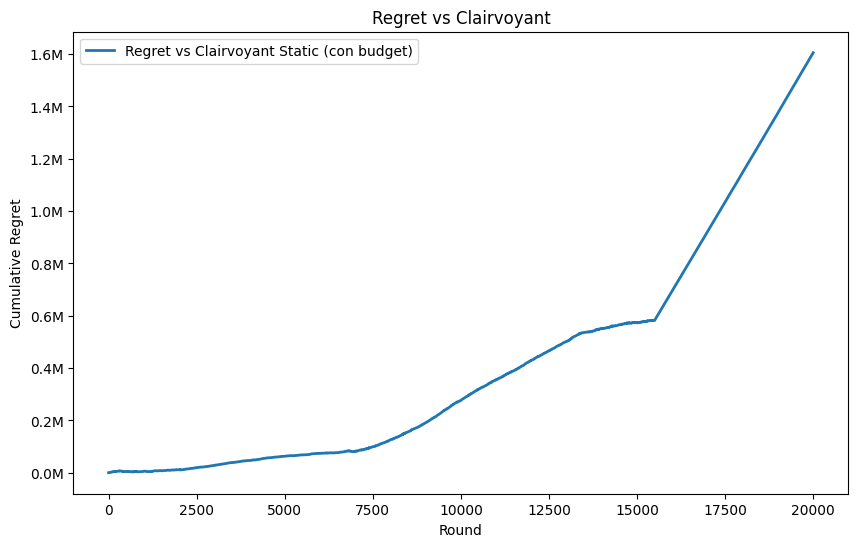

In [21]:
plt.figure(figsize=(10,6))
mean_regret_static = mean_clairvoyant_static - mean_cum_util
#mean_regret_dynamic = mean_clairvoyant_dynamic - mean_cum_util

plt.plot(mean_regret_static, label='Regret vs Clairvoyant Static (con budget)', linewidth=2)
#plt.plot(mean_regret_dynamic, label='Regret vs Clairvoyant Dynamic (senza budget)', linewidth=2)
plt.xlabel('Round')
plt.ylabel('Cumulative Regret')
plt.title('Regret vs Clairvoyant')
plt.gca().yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(millions_formatter))
_ = plt.legend()

#### Dynamic clairvoyant with piecewise agent

In [ ]:
clairvoyant_dynamic_rewards = []
all_price_indices = np.array(list(product(range(K), repeat=N)))
all_prices = P[all_price_indices]  # (num_combinations, N)

cumulative_reward = np.zeros(T)
env.current_round = 0  # reset env

for t in range(T):
    interval_index = t // (T // 3)
    mean_vals = env.mean_valuations_list[min(interval_index, 2)].reshape(1, -1)
    std_vals = std_valuations.reshape(1, -1)

    prob_buy = 1 - norm.cdf(all_prices, loc=mean_vals, scale=std_vals)
    expected_sales = prob_buy * buyers_per_round
    expected_reward = (all_prices - cost_vector) * expected_sales
    total_expected_reward = np.sum(expected_reward, axis=1)

    best_index = np.argmax(total_expected_reward)
    best_prices = all_prices[best_index]

    _, actual_rewards = env.round(best_prices)
    cumulative_reward[t] = cumulative_reward[t-1] + np.sum(actual_rewards) if t > 0 else np.sum(actual_rewards)

clairvoyant_dynamic_rewards = cumulative_reward.copy()
mean_clairvoyant_dynamic = clairvoyant_dynamic_rewards

print(f">>> Mean Final Reward for Dynamic Clairvoyant: {mean_clairvoyant_dynamic[-1]:.2f}")


In [22]:
# Inizializzazione
clairvoyant_nobudget_cum_rewards = []
cum_reward_nobudget = 0

remaining_budget_clairvoyant = B
clairvoyant_cum_rewards = []

# Stats per ogni prezzo (arm)
arm_stats = {
    p: {
        "reward": 0.0,
        "budget_spent": 0.0,
        "cum_rewards": [],
    }
    for p in P if p > cost_vector[0]
}

for t in range(T):
    # Trova l'indice dell'intervallo piecewise (0, 1 o 2)
    interval_index = t // (T // 3)
    mean_val_t = env.mean_valuations_list[min(interval_index, 2)][0]  # Un solo prodotto

    # Clairvoyant senza vincolo di budget: massimo reward atteso in questo round
    best_reward_this_round = -np.inf
    for p in arm_stats:
        prob_buy = 1 - norm.cdf(p, loc=mean_val_t, scale=std_valuations[0])
        expected_sales = prob_buy * buyers_per_round
        reward = expected_sales * (p - cost_vector[0])

        if reward > best_reward_this_round:
            best_reward_this_round = reward

    cum_reward_nobudget += best_reward_this_round
    clairvoyant_nobudget_cum_rewards.append(cum_reward_nobudget)

    # Clairvoyant con vincolo di budget: aggiorna ogni arm separatamente
    for p in arm_stats:
        stats = arm_stats[p]

        if stats["budget_spent"] >= B:
            stats["cum_rewards"].append(stats["reward"])
            continue

        prob_buy = 1 - norm.cdf(p, loc=mean_val_t, scale=std_valuations[0])
        expected_sales = prob_buy * buyers_per_round

        max_sales_affordable = (B - stats["budget_spent"]) / p
        actual_sales = min(expected_sales, max_sales_affordable)
        actual_cost = actual_sales * p
        actual_reward = actual_sales * (p - cost_vector[0])

        stats["budget_spent"] += actual_cost
        stats["reward"] += actual_reward
        stats["cum_rewards"].append(stats["reward"])

# Stampa dei risultati
print("\n--- Summary: Reward and Budget Used per Price (Arm) ---")
print(f"{'Price':>8} | {'Total Reward':>20} | {'Budget Used':>20}")
print("-" * 55)
for p in sorted(arm_stats):
    r = arm_stats[p]["reward"]
    b = arm_stats[p]["budget_spent"]
    print(f"{p:8.2f} | {r:20,.2f} | {b:20,.2f}")

best_arm = max(arm_stats, key=lambda p: arm_stats[p]["reward"])
print(f">>> Best arm: price = {best_arm}, reward = {arm_stats[best_arm]['reward']:.2f}")
print(f">>> Clairvoyant (no-budget): total reward = {cum_reward_nobudget:.2f}")



--- Summary: Reward and Budget Used per Price (Arm) ---
   Price |         Total Reward |          Budget Used
-------------------------------------------------------
    2.67 |            90,000.00 |           360,000.00
    4.00 |           180,000.00 |           360,000.00
    5.33 |           225,000.00 |           360,000.00
    6.67 |           252,000.00 |           360,000.00
    8.00 |           270,000.00 |           360,000.00
    9.33 |           282,857.14 |           360,000.00
   10.67 |           138,047.23 |           169,904.29
   12.00 |             4,499.21 |             5,399.05
>>> Best arm: price = 9.333333333333332, reward = 282857.14
>>> Clairvoyant (no-budget): total reward = 2270405.37


In [ ]:
# -----------------------------
# Clairvoyant 1: Static Mean Assumption (malgrado la domanda oscilli)
# -----------------------------

# Valutazione domanda attesa assumendo media statica (iniziale)
def expected_demand(p):
    return np.sum(1 - norm.cdf(p, loc=np.full(buyers_per_round, env.mean_valuations_list[0][0]), scale=1.0))

expected_demand_vector = np.array([expected_demand(p) for p in P])
expected_profit_vector = (P - cost_vector[0]) * expected_demand_vector

best_expected_index = np.argmax(expected_profit_vector)
best_expected_price = P[best_expected_index]
best_expected_profit = expected_profit_vector[best_expected_index]
best_expected_demand = expected_demand_vector[best_expected_index]

expected_cost_per_round = best_expected_demand * best_expected_price  # attenzione: prezzo, non costo di produzione

# Calcolo reward cumulativo considerando il budget
static_clairvoyant_cum_rewards = np.zeros(T)
cumulative_cost = 0

for t in range(T):
    if cumulative_cost + expected_cost_per_round <= B:
        static_clairvoyant_cum_rewards[t] = best_expected_profit
        cumulative_cost += expected_cost_per_round
    else:
        static_clairvoyant_cum_rewards[t] = 0.0

static_clairvoyant_cum_rewards = np.cumsum(static_clairvoyant_cum_rewards)
regret_static = static_clairvoyant_cum_rewards - mean_cum_util

print(f">>> Static Assumption Clairvoyant: best price = {best_expected_price:.2f}")
print(f">>> Expected profit assuming static demand = {best_expected_profit:.2f}")



>>> Static Assumption Clairvoyant: best price = 4.00
>>> Expected profit assuming static demand = 84.13

Remember the Fixed-Best Clairvoyant plays with oscillating demand


In [24]:
# -----------------------------
# Clairvoyant 2: Fixed-Best Clairvoyant
# -----------------------------

clairvoyant_cum_rewards = np.array(arm_stats[best_arm]["cum_rewards"])
regret_budget = clairvoyant_cum_rewards - mean_cum_util

# Trova primo round in cui il reward resta costante (fine budget)
budget_exhausted_round = np.argmax(np.isclose(np.diff(clairvoyant_cum_rewards), 0, atol=1e-8)) + 1


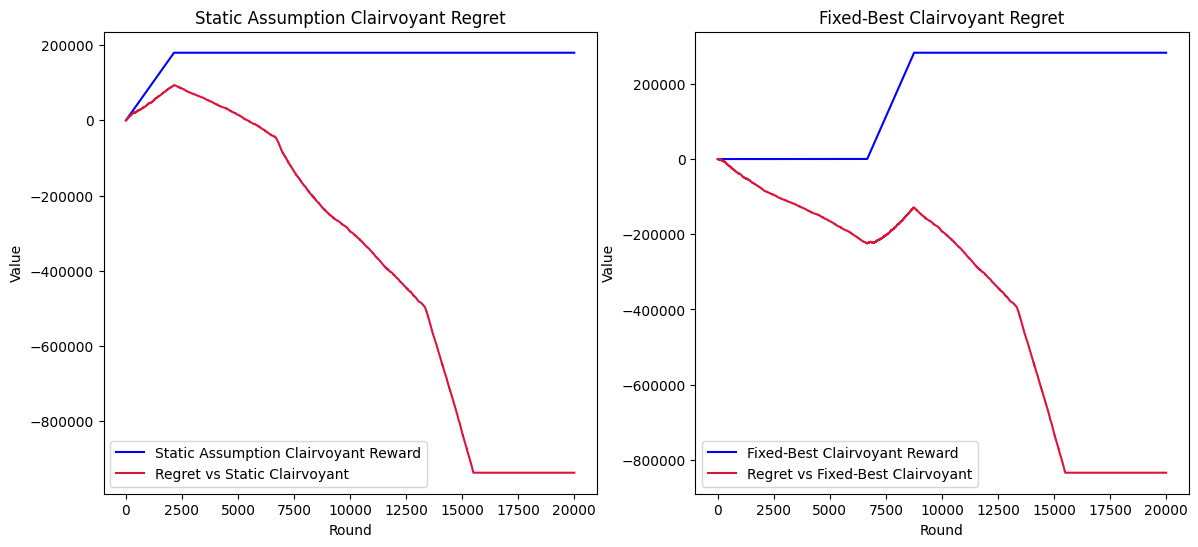

In [25]:
plt.figure(figsize=(14, 6))

# --- Subplot 1: Static ---
plt.subplot(1, 2, 1)
plt.plot(static_clairvoyant_cum_rewards, label='Static Assumption Clairvoyant Reward', color='blue')
plt.plot(regret_static, label='Regret vs Static Clairvoyant', color='crimson')
plt.xlabel("Round")
plt.ylabel("Value")
plt.title("Static Assumption Clairvoyant Regret")
plt.legend()

# --- Subplot 2: Fixed-Best ---
plt.subplot(1, 2, 2)
plt.plot(clairvoyant_cum_rewards, label='Fixed-Best Clairvoyant Reward', color='blue')
plt.plot(regret_budget, label='Regret vs Fixed-Best Clairvoyant', color='crimson')
plt.xlabel("Round")
plt.ylabel("Value")
plt.title("Fixed-Best Clairvoyant Regret")
plt.legend()
